# Sea ice plotting examples

This script shows how to load and plot sea ice concentration, area and extent from mom5 (ACCESS-OM2) and mom6 (PanAntarctic) output. In mom5, we also indicate how to get around some of the pitfalls and foibles in mom5 temporal and spatial gridding.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cf_xarray
import cmocean
import cosima_cookbook as cc
import dask.distributed as dask
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

Initialise a dask client, which helps for long time series:

In [2]:
client = dask.Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38813,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:35243,Total threads: 2
Dashboard: /proxy/38973/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:39643,


Start a database session to access COSIMA experiments:

In [3]:
session = cc.database.create_session()

The dictionary below specifies experiment, start and ending times for each model we can use (MOM5 or MOM6). This example will work with RYF forcing experiments and sea ice concentration variable, which is called `aice_m` in mom5 and `siconc` in mom6.

If you want a different experiment, or a different time period, change the necessary values. A tutorial on how to explore the database for available experiments is available [here](https://github.com/COSIMA/cosima-recipes/blob/master/Tutorials/COSIMA_CookBook_Tutorial.ipynb)

In [13]:
model_args = {"mom5": {"expt": "01deg_jra55v13_ryf9091",
                       "sea_ice_model": "mom55",
                       "sic_variable": "aice_m",
                       "area_variable": "area_t",
                       "start_time": "1991-01-01",
                       "end_time": "2001-01-01"},

              "mom6": {"expt": "panant-01-zstar-ACCESSyr2",
                       "sea_ice_model": "mom62",
                       "sic_variable": "siconc",
                       "area_variable": "areacello",
                       "start_time": "1991-01-01",
                       "end_time": "2001-01-01",
                       "frequency": "1 monthly"}
             }

## Loading data

The functions below load data for either model. There are a couple of obstacles to overcome with mom5:

 - mom5 grid and xarray don't work well together, so it is particularly important to set `decode_coord` to `False`. Also, mom5's coordinates are not longitude and latitude, so we will have to load them separately.
 - We also need to correct its time coordinate, since mom5 thinks that monthly data for, say, January occurs at midnight on Jan 31 -- while xarray interprets this as the first milllisecond of February. To get around this, note that we loaded data from February above, and we now subtract 12 hours from the time dimension. This means that, at least data is sitting in the correct month, and really helps to compute monthly climatologies correctly.

We don't have such issues in mom6.

In [9]:
def load_sea_ice_concentration(model):
    # Model can be set to 'mom5' or 'mom6'
    
    experiment = model_args[model]["expt"]
    variable = model_args[model]["sic_variable"]
    start_time = model_args[model]["start_time"]
    end_time = model_args[model]["end_time"]

    if model == "mom5":
        SIC = cc.querying.getvar(experiment, variable, session = session, start_time = start_time, end_time = end_time, decode_coords = False)
        # ensure we get the time-slice we wanted
        SIC = SIC.sel(time = slice(start_time, end_time))
        SIC["time"] = SIC.time.to_pandas() - timedelta(hours = 12)
        
        xt_ocean = cc.querying.getvar(experiment, 'xt_ocean', session = session, n = 1)
        yt_ocean = cc.querying.getvar(experiment, 'yt_ocean', session = session, n = 1)
        SIC = SIC.rename({'ni':'xt_ocean', 'nj':'yt_ocean'})
        SIC['xt_ocean'] = xt_ocean.values
        SIC['yt_ocean'] = yt_ocean.values
        
        # also, lets just select the Southern Ocean (who cares about ice in the subtropics!)
        SIC = SIC.sel(yt_ocean = slice(None, -50))

    elif model == "mom6":
        SIC = cc.querying.getvar(experiment, variable, session = session, frequency = '1 monthly', start_time = start_time, end_time = end_time)
        # ensure we get the time-slice we wanted
        SIC = SIC.sel(time = slice(start_time, end_time))
    
    return SIC

def load_area(model):

    experiment = model_args[model]["expt"]
    variable = model_args[model]["area_variable"]

    if model == "mom5":
        area = cc.querying.getvar(experiment, variable, session = session, n = 1)
        area = area.sel(yt_ocean = slice(None, -50))

    elif model == "mom6":
        area = cc.querying.getvar(experiment, variable, session = session, n = 1)
        area = area.rename({'xh':'xT', 'yh':'yT'})

    return area

Define a plotting function that draws a circumpolar map:

In [6]:
def circumpolar_map():
    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -80, -50], crs=ccrs.PlateCarree())

    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # Add land features and gridlines
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
                   facecolor = 'gainsboro'), zorder = 2)
    
    return fig, ax

## Sea ice concentration (SIC)

In [11]:
SIC_mom5 = load_sea_ice_concentration("mom5")
SIC_mom5

<xarray.DataArray 'aice_m' (time: 121, yt_ocean: 666, xt_ocean: 3600)>
dask.array<getitem, shape=(121, 666, 3600), dtype=float32, chunksize=(1, 666, 900), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1990-12-31 12:00:00 ... 2000-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -50.16 -50.09 -50.03
Attributes: (12/13)
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [14]:
SIC_mom6 = load_sea_ice_concentration("mom6")
SIC_mom6

<xarray.DataArray 'siconc' (time: 120, yT: 845, xT: 3600)>
dask.array<concatenate, shape=(120, 845, 3600), dtype=float32, chunksize=(1, 423, 1800), chunktype=numpy.ndarray>
Coordinates:
  * xT       (xT) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yT       (yT) float64 -81.11 -81.07 -81.02 -80.98 ... -37.3 -37.22 -37.14
  * time     (time) object 1991-01-16 12:00:00 ... 2000-12-16 12:00:00
Attributes:
    units:          0-1
    long_name:      ice concentration
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    ncfiles:        ['/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSy...

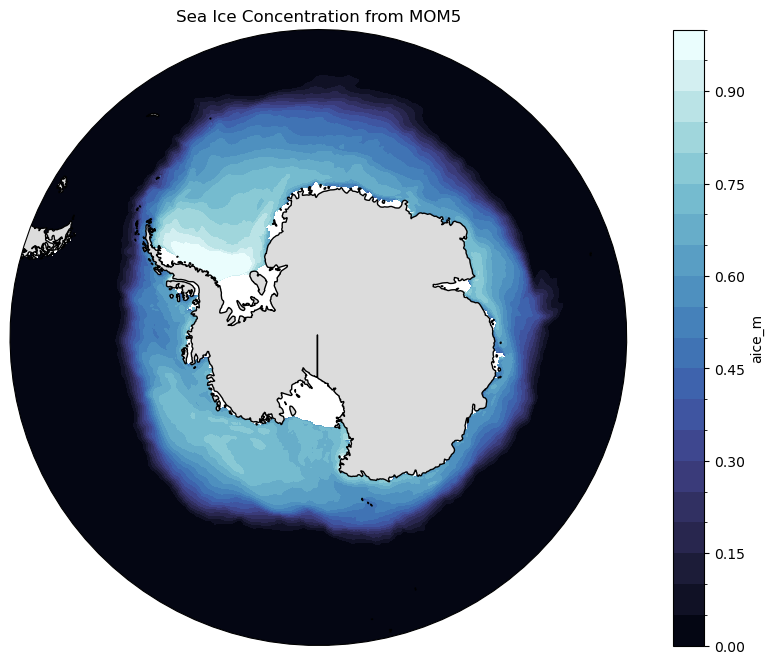

In [15]:
fig, ax = circumpolar_map()

# Plot time mean
SIC_mom5.cf.mean("time").cf.plot.contourf(ax = ax,
                                          longitude = 'longitude', latitude = 'latitude', 
                                          transform = ccrs.PlateCarree(),
                                          levels = np.arange(0,1.05,.05),
                                          cmap = cmocean.cm.ice)

plt.title('Sea Ice Concentration from MOM5');

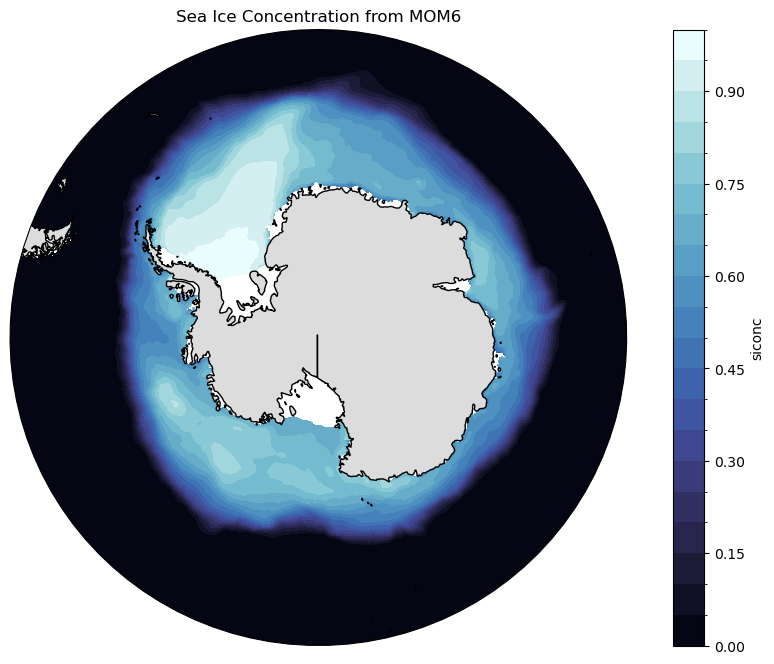

In [16]:
fig, ax = circumpolar_map()

# Plot time mean
SIC_mom6.cf.mean("time").cf.plot.contourf(ax = ax,
                                         x = 'longitude', y = 'latitude', 
                                         transform = ccrs.PlateCarree(),
                                         levels = np.arange(0,1.05,.05),
                                         cmap = cmocean.cm.ice)

plt.title('Sea Ice Concentration from MOM6');

## Sea ice area (SIA)

To calculate sea ice area, we need to multiply sea ice concentration by cell area. This should be easy because we already corrected mom5 coordinates to have lat lon values.

In [17]:
area_mom5 = load_area("mom5")
area_mom6 = load_area("mom6")

In [18]:
SIA_mom5 = SIC_mom5 * area_mom5
SIA_mom6 = SIC_mom6 * area_mom6

In [19]:
SIA_mom5 = SIA_mom5.rename('sea ice area')
SIA_mom6 = SIA_mom6.rename('sea ice area')

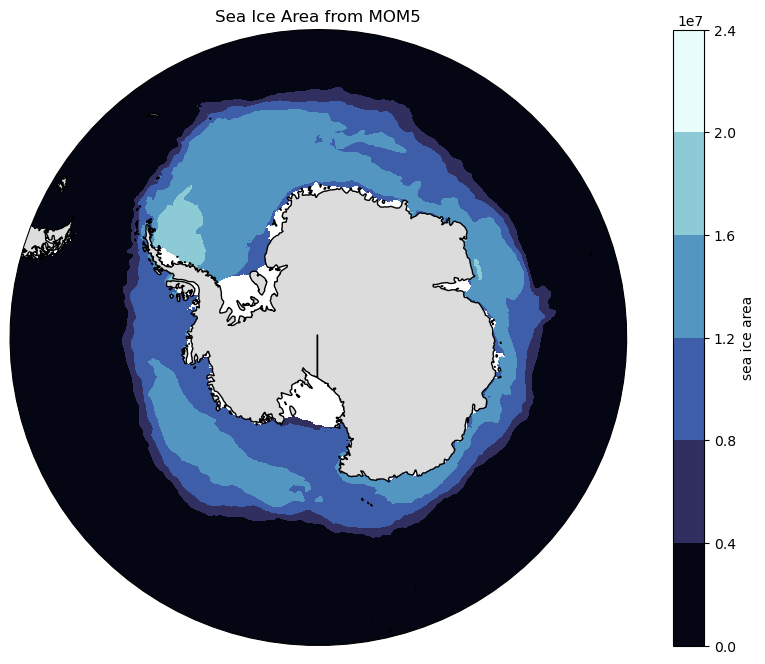

In [20]:
fig, ax = circumpolar_map()

# Plot time mean
SIA_mom5.cf.mean("time").cf.plot.contourf(ax = ax,
                                          x = 'longitude', y = 'latitude', 
                                          transform = ccrs.PlateCarree(),
                                          cmap = cmocean.cm.ice)

plt.title('Sea Ice Area from MOM5');

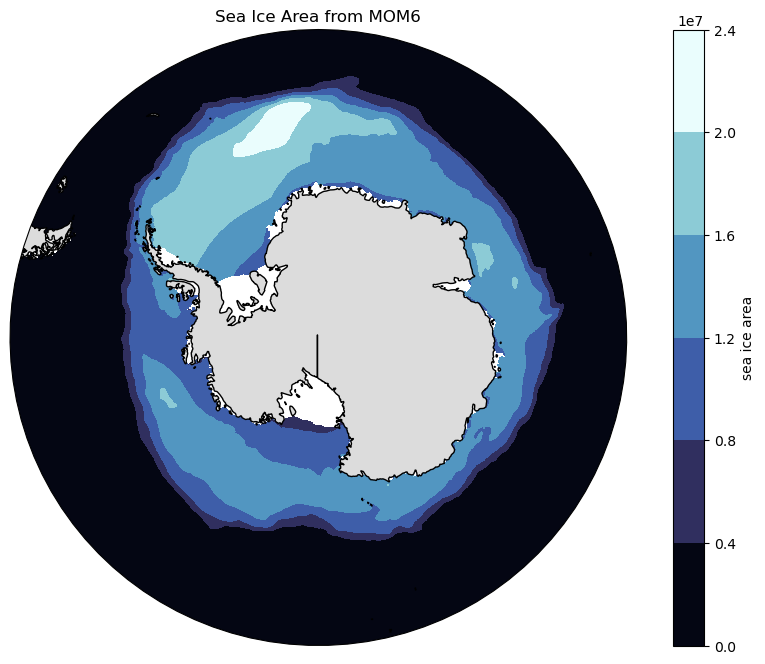

In [21]:
fig, ax = circumpolar_map()

# Plot time mean
SIA_mom6.cf.mean("time").cf.plot.contourf(ax = ax,
                                         x = 'longitude', y = 'latitude', 
                                         transform = ccrs.PlateCarree(),
                                         cmap = cmocean.cm.ice)

plt.title('Sea Ice Area from MOM6');

### Sea ice extent

For this, we need to sum sea ice area over all grid cells to get the total area of sea ice. We will do it for a seasonal cycle.

In [22]:
SIA_mom5_extent = SIA_mom5.groupby('time.month').mean('time').sum(['xt_ocean', 'yt_ocean']).rename('sea ice extent')

In [23]:
SIA_mom6_extent = SIA_mom6.groupby('time.month').mean('time').sum(['xT', 'yT']).rename('sea ice extent')

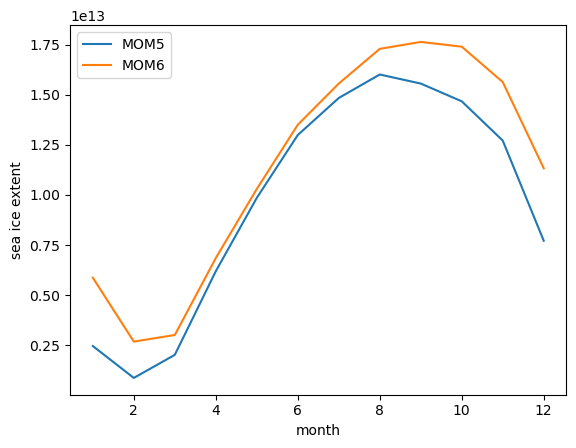

In [24]:
SIA_mom5_extent.plot(label = 'MOM5')
SIA_mom6_extent.plot(label = 'MOM6')
plt.legend();